In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
# from train import features, preprocess, encode_defaults, default_values
from src.utils import scale_scores
import math

In [4]:
modeling_df = pd.read_feather('../../data/combined_all_features/combined_1600654492.feather')
# transactions_df = pd.read_feather('../../data-transactional/labeled/labeled_1600730035.feather')

In [5]:
modeling_df = pd.read_feather('../../data/combined_all_features/combined_1600654492.feather')
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-09-18')]
active_accounts = modeling_df[(modeling_df.nr_past_transactions > 0) & (modeling_df.nr_transactions_30d > 0)].borrower_id.unique()
active_accounts = active_accounts.astype(int)
modeling_df['is_active'] = modeling_df.borrower_id.isin(active_accounts)

In [5]:
# bids = modeling_df[modeling_df.nr_trans_ratio.isna()]['borrower_id'].unique().astype(int)
# bids = set(bids).intersection(active_accounts)

In [6]:
modeling_df[modeling_df.is_active].shape

(60513, 107)

In [42]:
active_accounts.astype(int)

array([ 2285411,      657,       40, ..., 10509437, 10508672, 10511990])

<AxesSubplot:>

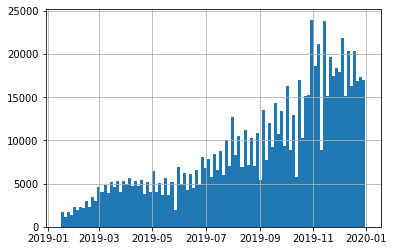

In [56]:
modeling_df = pd.read_feather('../../data/combined/combined_1600728877.feather')
modeling_df.sample_date.hist(bins=100)

### Look at transactional data

In [6]:
transactions_df = pd.read_feather('../../data-transactional/labeled/labeled_1600730035.feather')

In [7]:
transactions_df['is_active'] = transactions_df.borrower_id.isin(active_accounts)
transactions_df = transactions_df[transactions_df.is_active]

In [8]:
transactions_df.head()

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,is_active
0,0,2017-12-13 16:26:35,37722,410000007044,ACHDD,CO,False,500.00,500.00,False,...,False,False,13261.09,False,1.0,2453.03,False,False,False,True
1,1,2017-12-19 23:55:21,37722,410000007044,ACHDWIN,PAYPAL VERIFYBANK,False,-0.12,500.00,False,...,False,False,13261.09,False,1.0,2363.09,False,False,False,True
2,2,2017-12-19 23:55:21,37722,410000007044,ACHDDIN,PAYPAL VERIFYBANK,False,0.10,500.14,False,...,False,False,13261.09,False,1.0,2363.09,False,False,False,True
3,3,2017-12-19 23:55:21,37722,410000007044,ACHDDIN,PAYPAL VERIFYBANK,False,0.10,500.24,False,...,False,False,13261.09,False,1.0,2363.09,False,False,False,True
4,4,2017-12-19 23:55:21,37722,410000007044,ACHDWIN,PAYPAL VERIFYBANK,False,-0.14,500.12,False,...,False,False,13261.09,False,1.0,2363.09,False,False,False,True


In [9]:
transactions_df.borrower_id.nunique()

60512

In [11]:
transactions_df.borrower_id.unique()

array([   37722,  4834950,  3411668, ..., 10509437, 10508672, 10511990])

In [12]:
transactions_df.borrower_id.value_counts().sort_values(ascending=False)

4209991     5261
1465248     3820
1185989     3752
4673803     3732
6312724     3726
            ... 
10414457       2
10271241       2
10198094       2
2248376        1
10153942       1
Name: borrower_id, Length: 60512, dtype: int64

In [16]:
debug_df = transactions_df[transactions_df.borrower_id==1185989]

In [17]:
debug_df['nr_transactions_3d'] / debug_df['nr_transactions_30d']

1150413    1.000000
1150414    0.500000
1150415    0.666667
1150416    0.750000
1150417    0.800000
             ...   
1154160    0.094595
1154161    0.100671
1154162    0.093333
1154163    0.079470
1154164    0.041096
Length: 3752, dtype: float64

In [21]:
debug_df.sort_values(by=['transaction_datetime'])

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate,is_active
1150413,1150413,2018-09-02 14:52:19,1185989,410000158103,ACHDD,CO,False,500.00,500.00,False,...,False,False,6908.32,False,0.0,18981.55,False,False,False,True
1150414,1150414,2018-09-06 12:05:48,1185989,410000158103,POSDW,"MOBY DICK HOUSE OF KAB WASHINGTON, DC, US",False,-12.09,484.15,True,...,False,False,6908.32,False,0.0,14906.87,False,False,False,True
1150415,1150415,2018-09-06 20:53:50,1185989,410000158103,POSDW,"HARRIS TEETER #0 12960 HIGHLAND CROS HERNDON, ...",False,-3.76,496.24,True,...,False,False,6908.32,False,0.0,14926.87,False,False,False,True
1150416,1150416,2018-09-07 12:09:23,1185989,410000158103,POSDW,"CHOPT - DUPONT WASHINGTON, DC, US",False,-12.09,472.06,True,...,False,False,6908.32,False,0.0,14926.87,False,False,False,True
1150417,1150417,2018-09-07 20:49:14,1185989,410000158103,POSDW,"KORA RESTAURANT ARLINGTON, VA, US",False,-15.00,457.06,True,...,False,False,6908.32,False,0.0,14789.86,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154160,1154160,2020-08-27 19:43:55,1185989,410000158103,POSDW,"Dacha Navy Yard 202-9193800, DC",False,-12.56,1048.46,False,...,False,False,6908.32,False,0.0,6908.32,False,False,False,True
1154161,1154161,2020-08-27 19:44:44,1185989,410000158103,POSDW,"Bardo Brewery Washinton, DC",False,-17.00,949.51,False,...,False,False,6908.32,False,0.0,6908.32,False,False,False,True
1154162,1154162,2020-08-27 20:45:30,1185989,410000158103,POSDW,"DUE SOUTH DOCKSIDE WASHINGTON, DC",False,-23.38,966.51,False,...,False,False,6908.32,False,0.0,6908.32,False,False,False,True
1154163,1154163,2020-08-28 05:17:03,1185989,410000158103,POSDW,"APPLE.COM/BILL 866-712-7753, CA",False,-0.99,1061.02,False,...,False,False,6908.32,False,0.0,6908.32,False,False,False,True


In [23]:
active_df = transactions_df[transactions_df.is_active]

<AxesSubplot:>

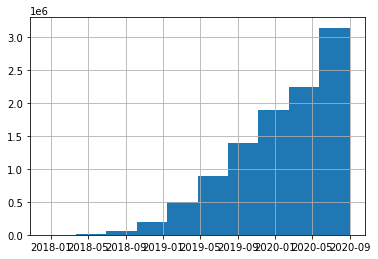

In [24]:
active_df.transaction_datetime.hist()

In [25]:
active_df.transaction_datetime.max()

Timestamp('2020-08-30 23:59:49')

In [26]:
transactions_df.transaction_datetime.max()

Timestamp('2020-08-30 23:59:49')

In [ ]:
query = """
SELECT tjd,
       dtj.time,
       dtj.cid AS business_account_number,
       cdt AS created_dt,
       endbal,
       dtj.etc AS transaction_code,
       tamt AS transaction_amount,
       trn.dc as is_credit,
       cif.zsofiid as user_id,
       split_part(split_part(tso, 'RCID#', 2), '~', 1) AS external_account_number,
       split_part(split_part(dtj.tso, 'RINS#', 2), '~', 1) AS external_institution_id,
       split_part(split_part(dtj.tso, 'ACHCOID#', 2), '~', 1) AS originating_company_id,
       split_part(split_part(dtj.tso, 'ACHID#', 2), '~', 1) AS external_institution_trans_id,
       split_part(split_part(dtj.tso, 'ACHODFI#', 2), '~', 1) AS originator_dfi_id,
       auth.merchnm AS merchant_name
FROM dtj
LEFT JOIN authdtl auth ON auth.authid = split_part(split_part(dtj.tso, 'AUTHID#', 2), '~', 1) AND dtj.tso LIKE '%%AUTHID#%%'
JOIN profile_reporting.dep ON dep.cid = dtj.cid
JOIN cif ON cif.acn = dep.acn
LEFT JOIN trn on dtj.etc = trn.etc
WHERE endbal IS NOT NULL
      and tamt IS NOT NULL
      and tamt NOT LIKE '%%#%%'
LIMIT 10;
"""

In [ ]:
from rdsutils.query import query_postgres

df = query_postgres(query=query,
                    port=15556,
                    database='sofi_profile_reporting')

In [2]:
modeling_df = pd.read_feather('../../data/combined/combined_1600752894.feather')

In [7]:
modeling_df.sample_date.max()

Timestamp('2020-09-18 00:00:00')